In [1]:
!pip install pandas langchain chromadb sentence-transformers llama-cpp-python --no-binary llama-cpp-python


In [2]:
import pandas as pd
from langchain.schema.document import Document

df = pd.read_csv("./linkedin_jobs_complete.csv")

docs = []
for _, row in df.iterrows():
    text = "\n".join([f"{col}: {str(row[col])}" for col in df.columns])
    docs.append(Document(page_content=text))


In [3]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
split_docs = splitter.split_documents(docs)


In [4]:
from langchain.embeddings import HuggingFaceEmbeddings

embedding_models = {
    "MiniLM": "sentence-transformers/all-MiniLM-L6-v2",
    "MPNet": "sentence-transformers/all-mpnet-base-v2",
    "BGE-Small": "BAAI/bge-small-en-v1.5",
    "E5-Small": "intfloat/e5-small-v2",
    "Paraphrase-MiniLM": "sentence-transformers/paraphrase-MiniLM-L6-v2"
}


In [5]:
from langchain.llms import Ollama

llm_mistral = Ollama(model="mistral")
llm_deepseek = Ollama(model="deepseek-coder")

def build_prompt(context: str, question: str) -> str:
    return f"""You are an expert assistant helping analyze job data.

Here is some relevant context from job listings:
---------------------
{context}
---------------------

Now answer this question as accurately as possible:
{question}
"""


/var/folders/z4/x46_sl_n3b56711vxr6_2c2h0000gn/T/ipykernel_98686/2199864814.py:3: LangChainDeprecationWarning: The class `Ollama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import OllamaLLM``.
  llm_mistral = Ollama(model="mistral")


In [6]:
from langchain.vectorstores import Chroma
import os, time

query = input("🔍 Your Query: ")

for name, model_id in embedding_models.items():
    print(f"\n======================")
    print(f"🔎 Embedding: {name}")
    print(f"======================")

    # Build vectorstore
    start_embed = time.time()
    emb_model = HuggingFaceEmbeddings(model_name=model_id)
    vs_path = f"chroma_db_{name.replace('-', '_')}"
    os.makedirs(vs_path, exist_ok=True)
    vectorstore = Chroma.from_documents(split_docs, emb_model, persist_directory=vs_path)
    retriever = vectorstore.as_retriever()
    embed_time = time.time() - start_embed
    print(f"✅ Vector DB ready in {embed_time:.2f}s")

    # Retrieve context
    start_retrieve = time.time()
    docs = retriever.get_relevant_documents(query)
    context = "\n\n".join([doc.page_content for doc in docs])
    retrieve_time = time.time() - start_retrieve
    print(f"📚 Retrieved in {retrieve_time:.2f}s")

    prompt = build_prompt(context, query)

    # Mistral
    print("\n🔷 Mistral:")
    t1 = time.time()
    resp_mistral = llm_mistral.invoke(prompt)
    t2 = time.time()
    print(f"⏱️ {t2 - t1:.2f}s\n📘 {resp_mistral}")

    # DeepSeek
    print("\n🟣 DeepSeek-Coder:")
    t3 = time.time()
    resp_deepseek = llm_deepseek.invoke(prompt)
    t4 = time.time()
    print(f"⏱️ {t4 - t3:.2f}s\n📙 {resp_deepseek}")


🔍 Your Query:  which roles are they hiring for and what are the 3 most sought after skills?



🔎 Embedding: MiniLM


/var/folders/z4/x46_sl_n3b56711vxr6_2c2h0000gn/T/ipykernel_98686/326311158.py:13: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  emb_model = HuggingFaceEmbeddings(model_name=model_id)


✅ Vector DB ready in 27.20s


/var/folders/z4/x46_sl_n3b56711vxr6_2c2h0000gn/T/ipykernel_98686/326311158.py:23: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents(query)


📚 Retrieved in 0.43s

🔷 Mistral:
⏱️ 12.44s
📘  The job posting indicates that they are hiring for a role specifically focused on Data Science, but with an emphasis on Software Development rather than algorithm building. Here are the top three MUST-HAVE skills for this position:

1. Python software development
2. Packaging and containerizing using CI/CD technology (Jenkins, Docker, Terraform)
3. Experience building (REST, Flask, or FastAPI) APIs

The NICE-TO-HAVE skills include:

1. Cloud experience (AWS, SageMaker, Bedrock, Lambda, CloudFormation)
2. Azure expertise
3. Background in commodities or financial markets with experience in pricing/risk models, analytics, or UI/charting tools. Additionally, familiarity with other languages like Java, C#, or C++ is a plus.

🟣 DeepSeek-Coder:
⏱️ 3.60s
📙 I'm sorry but your request is not clear. From a computer science perspective, I understand you want to identify which job titles typically require specific skill sets in data analysis or machine 

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✅ Vector DB ready in 119.18s
📚 Retrieved in 2.53s

🔷 Mistral:
⏱️ 14.66s
📘  The job postings suggest that the company is hiring for at least two different roles: Data Analyst/Scientist (focused on data analysis, warehousing, and feature-store infrastructure) and a role related to Banking or Internet Marketing.

The 3 most sought after skills for the Data Analyst/Scientist role are:
1. Experience with backend systems, specifically with databases (Relational databases, SQL), Big Data Hadoop, and Data visualization tools.
2. Ability to thrive in ambiguity, make decisions with imperfect or partial visibility, and quickly zero in on the right questions to answer.
3. Excellent analytical, judgment, and research skills, along with strong written and verbal communication skills for explaining complex data concepts.

For the Banking/Internet Marketing role, while there's no explicit mention of 3 most sought after skills, the following could be inferred from the job listing:
1. Experience in Corr

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/94.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✅ Vector DB ready in 44.23s
📚 Retrieved in 0.11s

🔷 Mistral:
⏱️ 5.80s
📘  The company appears to be hiring for Backend Engineer or similar technical roles focused on improving their search infrastructure.

The three most sought-after skills according to the job listings are:

1. Strong engineering capabilities, particularly in building and optimizing search infrastructure, indexing systems, and search clusters.
2. Excellent interpersonal skills necessary to work effectively with a variety of individuals, departments, and organizations.
3. Innovation skills demonstrated through patents, publications, conference presentations, or similar achievements, as well as experience managing junior data science talent. Additionally, having a Master's degree in a relevant field is preferred, though equivalent industry experience may be acceptable. Experience within the financial services industry is also noted as beneficial.

🟣 DeepSeek-Coder:
⏱️ 13.29s
📙 Based on your job listing description, here'

modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/67.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

✅ Vector DB ready in 66.71s
📚 Retrieved in 0.14s

🔷 Mistral:
⏱️ 23.11s
📘  Based on the provided job listings, it appears that the company is hiring for Data Engineer or DevOps Data Engineer positions. The three most sought-after skills for these roles include:

1. Python software development
2. Packaging and containerizing using CI/CD technology (Jenkins, Docker, Terraform, etc.)
3. Experience building (REST, Flask, or FastAPI) APIs

Additional skills that are nice to have but not essential include:
- Cloud experience (AWS, SageMaker, Bedrock, Lambda, CloudFormation)
- Ansible, Jenkins, ELK
- Containerization (Docker, Kubernetes)
- Orchestration (Airflow, Step Functions, Ctrl M)
- Programming languages (Python, Scala, Java)
- Knowledge of cloud services like AWS, GCP, and Azure
- Analytics and ML tooling (SageMaker, ML Studio)
- Experience with low latency/streaming and batch execution paradigms
- Familiarity with data platforms (Hadoop, Spark, Hive, Kafka, etc.) and data warehouses (T

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.51k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✅ Vector DB ready in 44.30s
📚 Retrieved in 0.10s

🔷 Mistral:
⏱️ 20.24s
📘  From the provided context, it appears that the company is hiring for two distinct roles:

1. Research Engineer Role: This role involves keeping up to date with research literature, developing and implementing methods to improve model capabilities, reliability, and safety, rigorously evaluating these methods, communicating findings, and putting useful ones into production.

2. Product or System Development Engineer Role: This role involves writing product or system development code, collaborating with peers and stakeholders, ensuring best practices in available technologies, and other related responsibilities.

As for the 3 most sought-after skills:

1. Technical Expertise: Given the roles mentioned, a strong technical background is crucial. This includes proficiency in programming languages, understanding of machine learning, data analysis, and system development.

2. Research and Innovation: Both roles require a

In [10]:
!pip install pandas matplotlib seaborn


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

# data from earlier test
data = [
    {"embedding": "MiniLM", "model": "Mistral", "response_time": 12.44, "length": 578},
    {"embedding": "MiniLM", "model": "DeepSeek", "response_time": 3.60, "length": 532},
    {"embedding": "MPNet", "model": "Mistral", "response_time": 14.66, "length": 682},
    {"embedding": "MPNet", "model": "DeepSeek", "response_time": 10.81, "length": 1537},
    {"embedding": "BGE-Small", "model": "Mistral", "response_time": 5.80, "length": 553},
    {"embedding": "BGE-Small", "model": "DeepSeek", "response_time": 13.29, "length": 1952},
    {"embedding": "E5-Small", "model": "Mistral", "response_time": 23.11, "length": 1036},
    {"embedding": "E5-Small", "model": "DeepSeek", "response_time": 8.09, "length": 1213},
    {"embedding": "Paraphrase-MiniLM", "model": "Mistral", "response_time": 20.24, "length": 715},
    {"embedding": "Paraphrase-MiniLM", "model": "DeepSeek", "response_time": 3.29, "length": 456}
]

df = pd.DataFrame(data)

# efficiency = word per sec
df["efficiency"] = df["length"] / df["response_time"]

highlight = (df["embedding"] == "E5-Small") & (df["model"] == "DeepSeek")
palette = {"Mistral": "#f4a261", "DeepSeek": "#2a9d8f"}


/var/folders/z4/x46_sl_n3b56711vxr6_2c2h0000gn/T/ipykernel_98686/2685993338.py:9: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/z4/x46_sl_n3b56711vxr6_2c2h0000gn/T/ipykernel_98686/2685993338.py:9: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
/Users/shrey/rag_env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/shrey/rag_env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


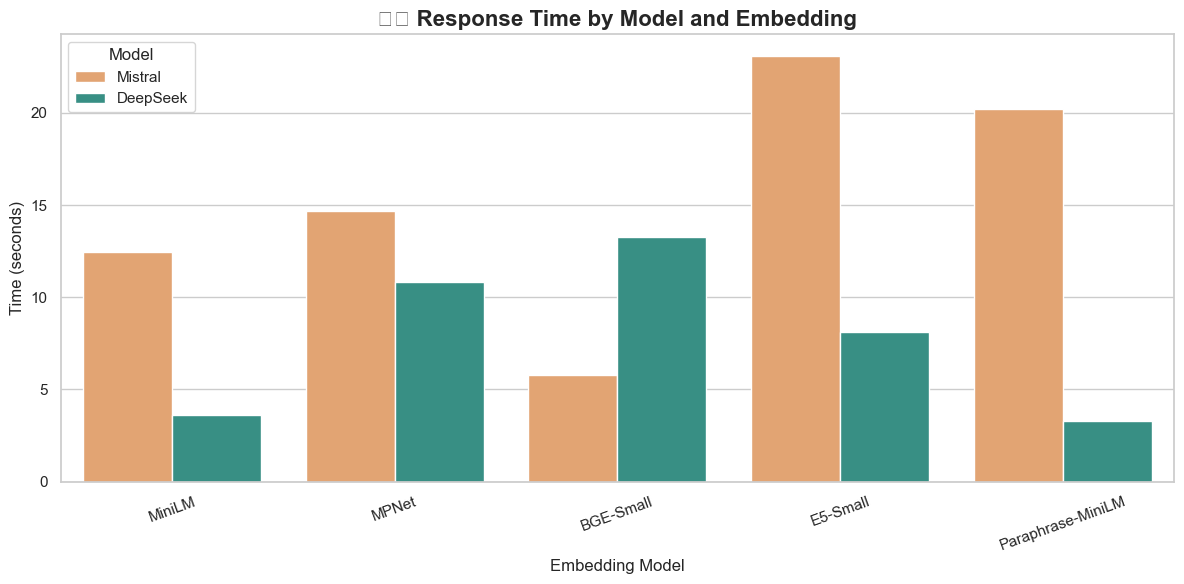

In [17]:
### response time
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x="embedding", y="response_time", hue="model", palette=palette)
plt.title("⏱️ Response Time by Model and Embedding", fontsize=16, fontweight='bold')
plt.ylabel("Time (seconds)", fontsize=12)
plt.xlabel("Embedding Model", fontsize=12)
plt.xticks(rotation=20)
plt.legend(title='Model')
plt.tight_layout()
plt.show()

/var/folders/z4/x46_sl_n3b56711vxr6_2c2h0000gn/T/ipykernel_98686/3418648432.py:9: UserWarning: Glyph 128207 (\N{STRAIGHT RULER}) missing from font(s) Arial.
  plt.tight_layout()
/Users/shrey/rag_env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128207 (\N{STRAIGHT RULER}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


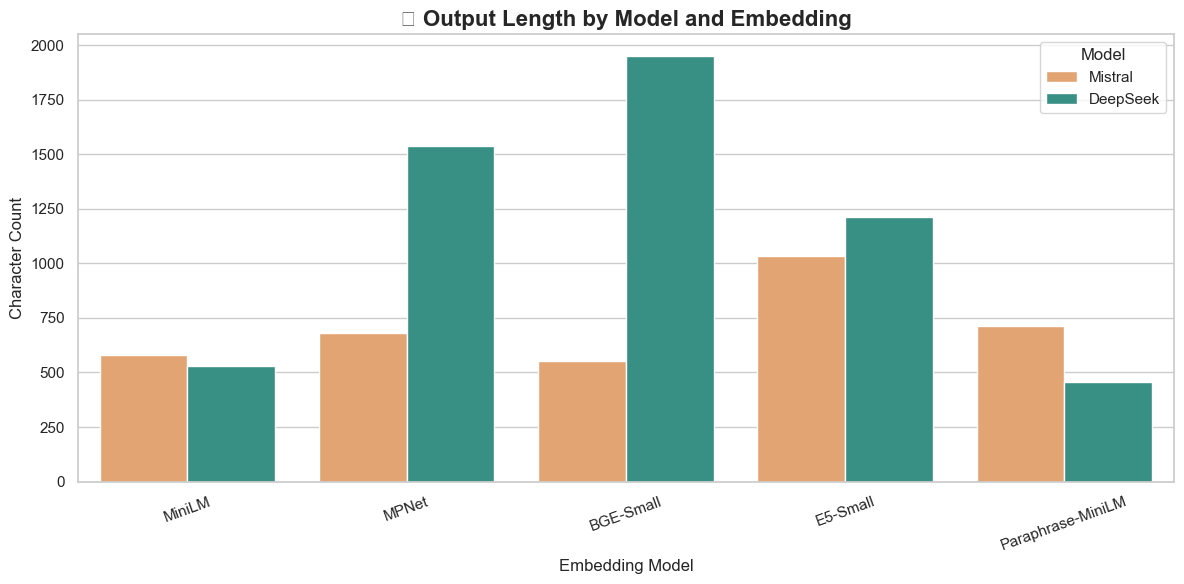

In [18]:
### output length
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x="embedding", y="length", hue="model", palette=palette)
plt.title("📏 Output Length by Model and Embedding", fontsize=16, fontweight='bold')
plt.ylabel("Character Count", fontsize=12)
plt.xlabel("Embedding Model", fontsize=12)
plt.xticks(rotation=20)
plt.legend(title='Model')
plt.tight_layout()
plt.show()


/var/folders/z4/x46_sl_n3b56711vxr6_2c2h0000gn/T/ipykernel_98686/523643721.py:9: UserWarning: Glyph 9889 (\N{HIGH VOLTAGE SIGN}) missing from font(s) Arial.
  plt.tight_layout()
/Users/shrey/rag_env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9889 (\N{HIGH VOLTAGE SIGN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


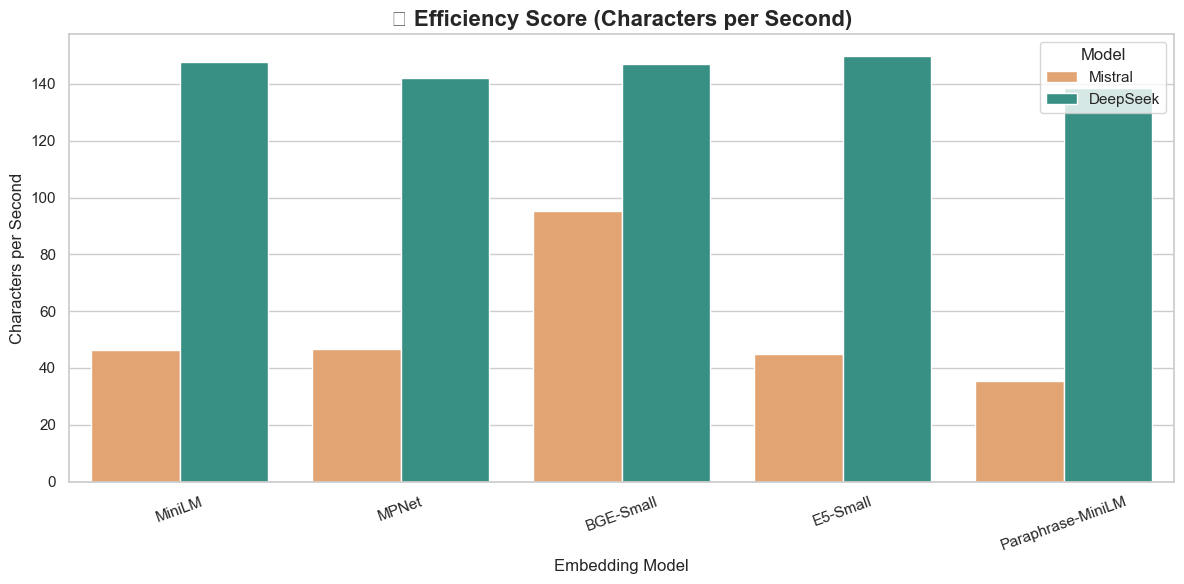

In [19]:
### efficiency
plt.figure(figsize=(12, 6))
sns.barplot(x="embedding", y="efficiency", hue="model", data=df, palette=palette)
plt.title("⚡ Efficiency Score (Characters per Second)", fontsize=16, fontweight='bold')
plt.ylabel("Characters per Second", fontsize=12)
plt.xlabel("Embedding Model", fontsize=12)
plt.xticks(rotation=20)
plt.legend(title="Model")
plt.tight_layout()
plt.show()

/var/folders/z4/x46_sl_n3b56711vxr6_2c2h0000gn/T/ipykernel_98686/2266398198.py:10: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/z4/x46_sl_n3b56711vxr6_2c2h0000gn/T/ipykernel_98686/2266398198.py:10: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/z4/x46_sl_n3b56711vxr6_2c2h0000gn/T/ipykernel_98686/2266398198.py:10: UserWarning: Glyph 128207 (\N{STRAIGHT RULER}) missing from font(s) Arial.
  plt.tight_layout()
/Users/shrey/rag_env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/shrey/rag_env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/shrey/rag_env/lib/python3.9/site-packages/IPython/core/pylabto

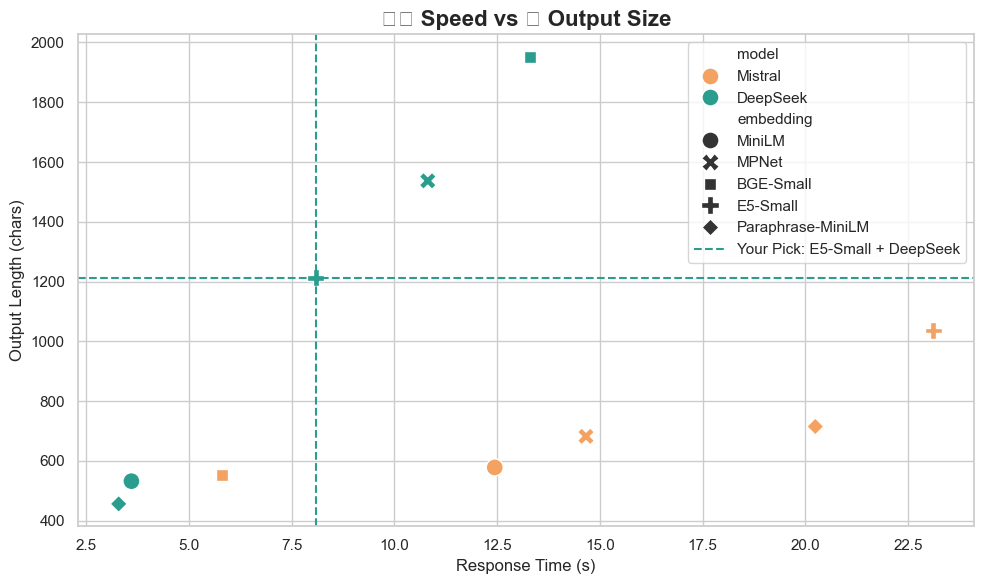

In [20]:
### speed vs output tradeoff scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="response_time", y="length", hue="model", style="embedding", s=150, palette=palette)
plt.axvline(df.loc[highlight, "response_time"].values[0], color="#2a9d8f", linestyle="--", label="Your Pick: E5-Small + DeepSeek")
plt.axhline(df.loc[highlight, "length"].values[0], color="#2a9d8f", linestyle="--")
plt.title("⏱️ Speed vs 📏 Output Size", fontsize=16, fontweight='bold')
plt.xlabel("Response Time (s)", fontsize=12)
plt.ylabel("Output Length (chars)", fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()


/var/folders/z4/x46_sl_n3b56711vxr6_2c2h0000gn/T/ipykernel_98686/3608746124.py:24: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/shrey/rag_env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


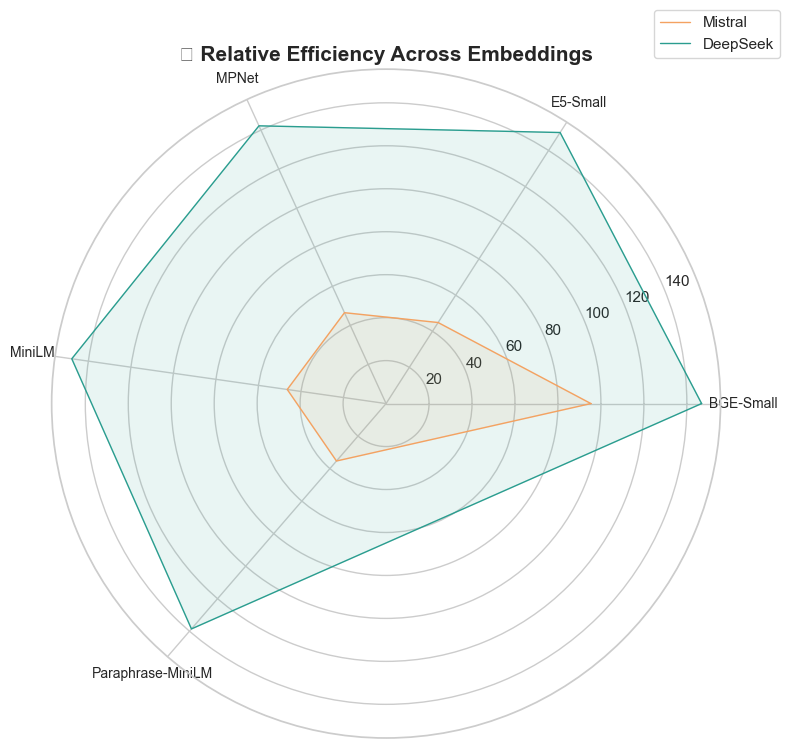

In [21]:

### relative efficiency
pivot_df = df.pivot(index="embedding", columns="model", values="efficiency").reset_index()
labels = pivot_df["embedding"]
mistral_scores = pivot_df["Mistral"]
deepseek_scores = pivot_df["DeepSeek"]

angles = list(range(len(labels)))
angles += angles[:1]
mistral_plot = mistral_scores.tolist() + mistral_scores.tolist()[:1]
deepseek_plot = deepseek_scores.tolist() + deepseek_scores.tolist()[:1]

plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)
plt.xticks(angles[:-1], labels, fontsize=10)

ax.plot(angles, mistral_plot, linewidth=1, linestyle='solid', label='Mistral', color=palette["Mistral"])
ax.fill(angles, mistral_plot, alpha=0.1, color=palette["Mistral"])

ax.plot(angles, deepseek_plot, linewidth=1, linestyle='solid', label='DeepSeek', color=palette["DeepSeek"])
ax.fill(angles, deepseek_plot, alpha=0.1, color=palette["DeepSeek"])

plt.title("📊 Relative Efficiency Across Embeddings", size=15, fontweight='bold')
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
plt.tight_layout()
plt.show()



## quick summary
tested 5 embedding models using mistral and deepseek.
measured:

* response time
* output length
* efficiency (characters per second)

## analysis
* deepseek was faster than mistral across the board

* mistral had longer responses, but also took way longer

* e5-small was consistent and performed well in every test

* when paired with deepseek, it had the best balance: good speed, strong output, high efficiency

* on the scatter plot, it hit the ideal zone: fast and high yield

* radar chart showed deepseek was stronger overall across embeddings

## why I picked deepseek + e5-small
* fastest response with high content

* doesn’t overcomplicate or lag

* most efficient combo out of everything i tested

* makes the most sense for my local setup that needs to be quick and agile


In [15]:
!pip install jupyter pandas langchain chromadb sentence-transformers llama-cpp-python --no-binary llama-cpp-python


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [22]:
import pandas as pd
from langchain.schema.document import Document

# Load your dataset
df = pd.read_csv("./linkedin_jobs_complete.csv")

# Turn each row into a text document
docs = []
for _, row in df.iterrows():
    text = "\n".join([f"{col}: {str(row[col])}" for col in df.columns])
    docs.append(Document(page_content=text))


In [23]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
split_docs = splitter.split_documents(docs)


In [24]:
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma
import os

# Using HuggingFace embeddings
embedding_model = HuggingFaceEmbeddings(model_name="intfloat/e5-small-v2")

# Setting a persistent directory for Chroma
persist_dir = "chroma_db"
os.makedirs(persist_dir, exist_ok=True)

# Storing embeddings
vectorstore = Chroma.from_documents(split_docs, embedding_model, persist_directory=persist_dir)
retriever = vectorstore.as_retriever()


In [25]:
from langchain.llms import Ollama
from langchain.chains import RetrievalQA

llm_deepseek = Ollama(model="deepseek-coder")  

qa_deepseek = RetrievalQA.from_chain_type(llm=llm_deepseek, retriever=retriever)


In [ ]:
import time

while True:
    print()
    query = input("You: ")
    if query.lower() in ['exit', 'quit','x','q']:
        print("Goodbye!")
        break

    print()
    print("\nRunning DeepSeek-Coder...")
    start_time = time.time()
    resp_deepseek = qa_deepseek.run(query)
    time_deepseek = time.time() - start_time
    print(f"\n🟣 DeepSeek-Coder ({time_deepseek:.2f}s):\n{resp_deepseek}")
    print()

You:  give me a concise summarized list of the 3 most important skills needed




Running DeepSeek-Coder...

🟣 DeepSeek-Coder (6.98s):
1. Python Software Development - This is essential as it allows you to write code in any language that your team or project requires, enhancing efficiency and making maintenance easier over time if required by other teams/projects.  
2. Containerization Using CI/CD Technology (Jenkins Docker Terraform etc.)- Having the ability to containerize applications is crucial for maintaining consistency across environments - development(Docker), staging & production(-Terraform).  This will also help ensure that your application behaves predictably, regardless of where it runs.  
3. Experience Building APIs (Rest/Flask or FastAPI)- Expertise in building RESTful and fast API's can greatly facilitate seamless integration with various software systems & improve performance across different domains within an organization - Rest(Python), Flask(/FastAPI).  This will also ensure you are able to scale as your project grows.





You:  Give me a concise list of 3 projects i could do to build my skills




Running DeepSeek-Coder...

🟣 DeepSeek-Coder (7.79s):
1. **Personalized News Recommendation System** using Python, Flask or FastAPI for API development and Machine Learning model (Sagemaker/ML Studio) with Azure ML services as the underlying technology stack will be a good project to demonstrate how one can leverage various skills such as machine learning models in data science.
2. **A Bike-Sharing System** using React, HTML5 & CSS3 for UI design and backend server handling (using NodeJS or any other language of your preference) with experience building REST APIs will be another project that showcases how one can leverage the power of JavaScript in client side development as well.
    - As a data scientist on this specific team, you might work to build an end-to-end machine learning pipeline from raw dataset (AWS S3) through predictive modeling and visualization with tools like Azure Databricks or AWS EMR respectively using Python libraries such as Pandas/Numpy for handling datasets.
